<a href="https://colab.research.google.com/github/ArjunNarayan2066/Test/blob/master/MySemanticSegmentation_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
from os.path import exists
if (exists('images') == False):
    print('Copying Images')
    !cp -r "drive/My Drive/cs484/images/" .
if (exists('lib') == False):
    print('Copying Lib')
    !cp -r "drive/My Drive/cs484/lib/" .
# if (exists('dataset') == False):
#     print('Copying Dataset')
#     !cp -r "drive/My Drive/cs484/dataset" .

### CS 484/684 Computational Vision
#### credits: many thanks for the design of this assignemnt go to <a href="https://tovacinni.github.io/" target = "_blank">Towaki Takikawa</a> 

# Homework Assignment #5 - Supervised Deep Learning for Segmentation

This assignment will test your understanding of applying deep learning by having you apply (fully supervised) deep learning to semantic segmentation, a well studied problem in computer vision. 

You can get most of the work done using only CPU, however, the use of GPU will be helpful in later parts. Programming and debugging everything upto and including problem 5c should be fine on CPU. You will notice the benefit of GPU mostly in later parts (d-h) of problem 5, but they are mainly implemenmted and test your code written and debugged earlier. If you do not have a GPU readily accesible to you, we recommend that you use Google Colaboratory to get access to a GPU. Once you are satisfied with your code upto and including 5(c), simply upload this Jupyter Notebook to Google Colaboratory to run the tests in later parts of Problem 5.

Proficiency with PyTorch is required. Working through the PyTorch tutorials will make this assignment significantly easier. https://pytorch.org/tutorials/

In [37]:
# Python Libraries
import random
import math
import numbers
import platform
import copy
from IPython.core.debugger import set_trace

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries used for HW4.
# Detailed installation instructions are here: https://pytorch.org/get-started/locally/
# That web site should help you to select the right 'conda install' command to be run in 'Anaconda Prompt'.
# In particular, select the right version of CUDA. Note that prior to installing PyTorch, you should  
# install the latest driver for your GPU and CUDA (9.2 or 10.1), assuming your GPU supports it. 
# For more information about pytorch refer to 
# https://pytorch.org/docs/stable/nn.functional.html
# https://pytorch.org/docs/stable/data.html.
# and https://pytorch.org/docs/stable/torchvision/transforms.html
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torch.optim as optim

!export CUDA_LAUNCH_BLOCKING=1
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name())

# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined

True


In [38]:
%matplotlib inline

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = torch.cuda.is_available()

In [39]:
!pip install chainercv # Need to manualy install this in the colab environment

# ChainerCV is a library similar to TorchVision, created and maintained by Preferred Networks. 
# Chainer, the base library, inspired and led to the creation of PyTorch! 
# Although Chainer and PyTorch are different, there are some nice functionalities in ChainerCV 
# that are useful, so we include it as an excersice on learning other libraries.
# To install ChainerCV, normally it suffices to run "pip install chainercv" inside "Anaconda Prompt".
# For more detailed installation instructions, see https://chainercv.readthedocs.io/en/stable/install.html
# For other information about ChainerCV library, refer to https://chainercv.readthedocs.io/en/stable/ 
from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [40]:
# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

VOC Root: drive/My Drive/cs484/dataset
VOC Root: drive/My Drive/cs484/dataset


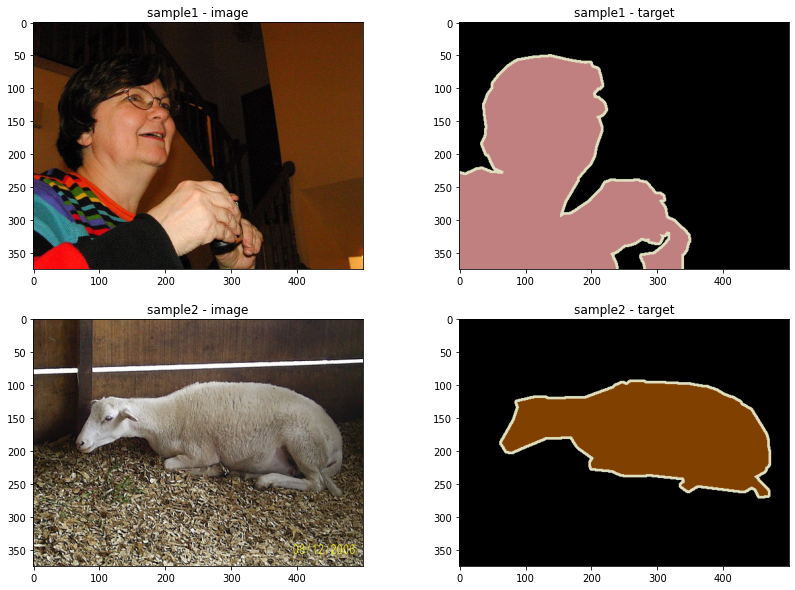

In [41]:
# Below we will use a sample image-target pair from VOC training dataset to test your joint transforms. 
# Running this block will automatically download the PASCAL VOC Dataset (3.7GB) to DATASET_PATH if "download = True".
# The code below creates subdirectory "datasets" in the same location as the notebook file, but
# you can modify DATASET_PATH to download the dataset to any custom directory. Download takes a few minutes.
# On subsequent runs you may save time by setting "download = False" (the default value of this flag)

# We provide our own implementation of torchvision.datasets.voc (containing popular "Pascal" dataset)
# that allows us to easily create single-image datasets
from lib.voc import VOCSegmentation
DATASET_PATH = 'drive/My Drive/cs484/dataset'

# Here, we obtain and visualize one sample (img, target) pair from VOC training dataset and one from validation dataset. 
# Note that operator [...] extracts the sample corresponding to the specified index. 
# Also, note the parameter download = True. Set this to False after you download to save time on later runs.
sample1 = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[200]
sample2 = VOCSegmentation(DATASET_PATH, image_set='val')[20]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

VOC Root: drive/My Drive/cs484/dataset


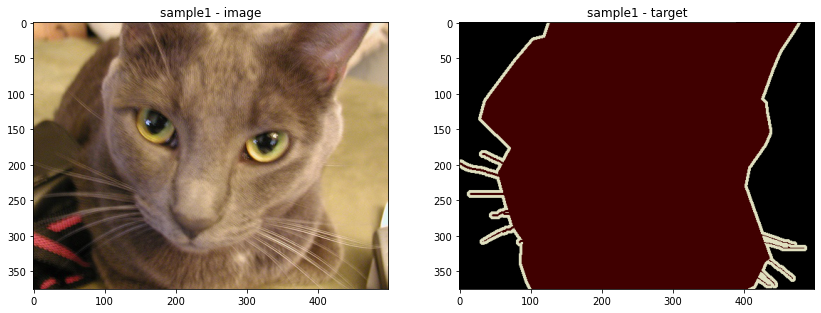

In [42]:
some_img = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[300]
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,2,1)
plt.title('sample1 - image')
ax1.imshow(some_img[0])
ax2 = fig.add_subplot(1,2,2)
plt.title('sample1 - target')
ax2.imshow(some_img[1])

# Problem 1 

#### Implement a set of "Joint Transform" functions to perform data augmentation in your dataset. 

Neural networks are typically applied to transformed images. There are several important reasons for this: 

1. The image data should is in certain required format (i.e. consistent spacial resolution to batch). The images should also be normalized and converted to the "tensor" data format expected by pytorch libraries. 

2. Some transforms are used to perform randomized image domain transformations with the purpose of "data augmentation". 

In this exercise, you will implement a set of different transform functions to do both of these things. Note that unlike classification nets, training semantic segmentation networks requires that some of the transforms are applied to both image and the corresponding "target" (Ground Truth segmentation mask). We refer to such transforms and their compositions as "Joint". In general, your Transform classes should take as the input both the image and the target, and return a tuple of the transformed input image and target. Be sure to use critical thinking to determine if you can apply the same transform function to both the input and the output.

For this problem you may use any of the `torchvision.transforms.functional` functions. For inspiration, refer to:
#### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#### https://pytorch.org/docs/stable/torchvision/transforms.html#module-torchvision.transforms.functional

#### Example 1

This class takes a img, target pair, and then transform the pair such that they are in `Torch.Tensor()` format.

#### Solution:

In [43]:
class JointToTensor(object):
    def __call__(self, img, target):
        # print(target.max())
        return tF.to_tensor(img), torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long()

tensor(17)


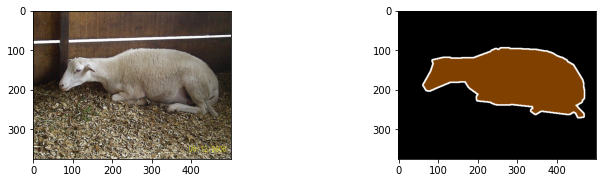

In [44]:
# Check the transform by passing the image-target sample.

img, target = JointToTensor()(*sample2)
print(target[target!=255].max())
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img.permute(1,2,0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(target.numpy()))

#### Example 2: 

This class implements CenterCrop that takes an img, target pair, and then apply a crop about the center of the image such that the output resolution is $\mbox{size} \times \mbox{size}$.

#### Solution:

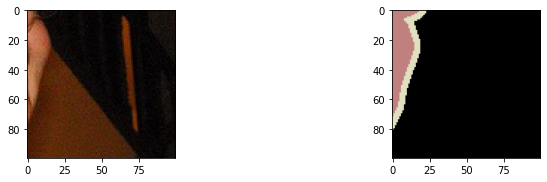

In [45]:
class JointCenterCrop(object):
    def __init__(self, size):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        
    def __call__(self, img, target):
        return (tF.five_crop(img, self.size)[4], 
                tF.five_crop(target, self.size)[4])
    
img, target = JointCenterCrop(100)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### (a) Implement RandomFlip

This class should take a img, target pair and then apply a horizontal flip across the vertical axis at random.

#### Solution:

In [46]:
class JointRandomFlip(object): 
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
            img, target = JointToTensor()(img, target)

        if np.random.randint(2):
            return (tF.hflip(img), tF.hflip(target))
        else:
            return (img, target)

tensor(17)


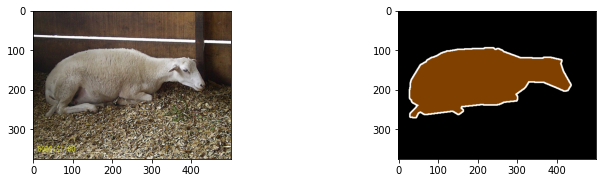

In [47]:
img, target = JointRandomFlip()(*sample2)
print(target[target!=255].max())
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img.permute(1,2,0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(target.numpy()))

#### (b) Implement RandomResizeCrop

This class should take a img, target pair and then resize the images by a random scale between $[\mbox{minimum_scale}, \mbox{maximum_scale}]$, crop a random location of the image by $\min(\mbox{size}, \mbox{image_height}, \mbox{image_width})$ (where the size is passed in as an integer in the constructor), and then resize to $\mbox{size} \times \mbox{size}$ (again, the size passed in). The crop box should fit within the image.

#### Solution:

In [48]:
class JointRandomResizeCrop(object):
    def __init__(self, min_scale, max_scale, size):
        self.min_scale = min_scale
        self.max_scale = max_scale
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size,size)

        self.scale_len = self.max_scale - self.min_scale

    def __call__(self, img, target):
        if not isinstance(img, PIL.Image.Image):
            target = transforms.ToPILImage()(target.type(torch.IntTensor))
            img = transforms.ToPILImage()(img)

        # Select Random Resize Scale
        scale = (np.random.rand() * (self.scale_len)) + self.min_scale
        rescaled_size = (int(img.size[0]*scale), int(img.size[1]*scale))
        rescaled_img = tF.resize(img, rescaled_size[::-1])
        rescaled_target = tF.resize(target, rescaled_size[::-1], interpolation=PIL.Image.NEAREST)

        # Crop Then Resize
        crop_size = min((self.size[0],self.size[1], rescaled_img.size[0]-1, rescaled_img.size[1]-1))
        crop_c = np.random.randint(0, rescaled_img.size[0] - crop_size)
        crop_r = np.random.randint(0, rescaled_img.size[1] - crop_size)

        final_img = tF.resized_crop(rescaled_img, crop_r, crop_c, crop_size, crop_size, size=self.size)
        final_target= tF.resized_crop(rescaled_target, crop_r, crop_c, crop_size, crop_size, size=self.size, interpolation=PIL.Image.NEAREST)

        final_img, final_target = JointToTensor()(final_img, final_target)
        return final_img, final_target.type(torch.LongTensor)

tensor(17)
torch.Size([3, 256, 256])


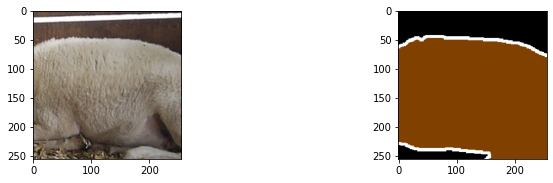

In [49]:
# print(sample1[0].size)
final_img, final_target = JointRandomResizeCrop(0.5, 1.5, 256)(*JointToTensor()(*sample2))
print(final_target[final_target!=255].max())
print(final_img.size())
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
# ax1.imshow(colorize_mask(target.numpy()))
ax1.imshow(final_img.permute(1,2,0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(final_target.numpy()))
# plt.show()

#### (c) Implement Normalize

This class should take a img, target pair and then normalize the images by subtracting the mean and dividing variance. 

#### Solution:

In [50]:
class JointResize(object):
    def __init__(self, size):
        self.size = size
    
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
            img, target = JointToTensor()(img, target)

        # print(img[None].shape)
        img = tF.resize(img[None], self.size)[0]#self.size)
        target = tF.resize(target[None], size=self.size, interpolation=PIL.Image.NEAREST)[0]
        # print(img.shape)

        return img, target

In [51]:
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]) 
# means = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225] 

class JointNormalize(object): 
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
          
    def __call__(self, img, target):
        if not isinstance(img, torch.Tensor):
            img, target = JointToTensor()(img, target)
        # target = target.double()
        # img_means = [img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean()]
        # img_std = [img[:,:,0].std(), img[:,:,1].std(), img[:,:,2].img_std()]
        # target_means = [target[:,:,0].mean(), target[:,:,1].mean(), target[:,:,2].mean()]
        # target_std = [target[:,:,0].std(), target[:,:,1].std(), target[:,:,2].std()]

        # Normalize
        norm_img = tF.normalize(img, self.mean, self.std)
        # Rescale to 0-1
        norm_img -= norm_img.min()
        norm_img /= norm_img.max()

        # norm_target = tF.normalize(target, target.mean(), target.std())
        # norm_target = ((target - target.mean()) / target.std()).long()
        # print(norm_target)

        return norm_img, target


tensor(17)


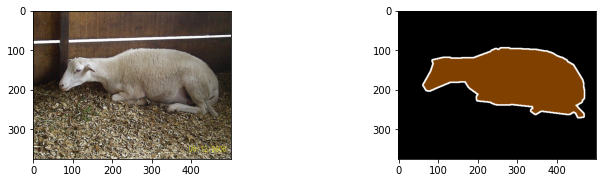

In [52]:
# fixed_img, fixed_target = JointNormalize(*norm)(*sample1)
fixed_img, fixed_target = JointResize((375,500))(*sample2)
print(fixed_target[fixed_target!=255].max())
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(fixed_img.permute(1,2,0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(fixed_target.numpy()))

#### (d) Compose the transforms together: 
##### Use `JointCompose` (fully implemeted below) to compose the implemented transforms together in some random order. Verify the output makes sense and visualize it.

In [53]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. This cell is fully implemented.

class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

<built-in method size of Tensor object at 0x7f03ec593828>


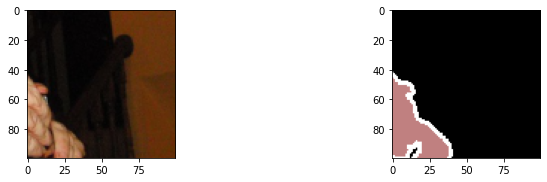

In [54]:
# Student Answer:
tfs = [JointToTensor(), JointRandomResizeCrop(0.5, 0.8, 100), JointRandomFlip()]

img, target = JointCompose(tfs)(*sample1)
print(img.size)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img.permute(1,2,0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(colorize_mask(target.numpy()))

#### (e) Compose the transforms together: use `JointCompose` to compose the implemented transforms for:
#### 1. A sanity dataset that will contain 1 single image. Your objective is to overfit on this 1 image, so choose your transforms and parameters accordingly.
#### 2. A training dataset that will contain the training images. The goal here is to generalize to the validation set, which is unseen.
#### 3. A validation dataset that will contain the validation images. The goal here is to measure the 'true' performance.

In [55]:
# Student Answer:

sanity_joint_transform  = JointCompose([JointToTensor(), JointNormalize(*norm)])#, JointRandomResizeCrop(0.5, 1.5, (375,500))])

train_joint_transform   = JointCompose([JointToTensor(), JointNormalize(*norm), JointRandomFlip(), JointRandomResizeCrop(0.5, 1.5, (375,500))])

val_joint_transform     = JointCompose([JointToTensor(), JointRandomFlip()])

This code below will then apply `train_joint_transform` to the entire dataset.

In [56]:
# Apply the Joint-Compose transformations above to create three datasets and the corresponding Data-Loaders.
# This cell is fully implemented.

# This single image data(sub)set can help to better understand and to debug the network training process. 
# Optional integer parameter 'sanity_check' specifies the index of the image-target pair and creates a single image dataset.
# Note that we use the same image (index=200) as used for sample1.
sanity_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = sanity_joint_transform,
    sanity_check = 200
)

# This is a standard VOC data(sub)set used for training semantic segmentation networks
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = train_joint_transform,
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = val_joint_transform
)

# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 64 # 1 default

# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS =  4 # default

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

VOC Root: drive/My Drive/cs484/dataset
VOC Root: drive/My Drive/cs484/dataset
VOC Root: drive/My Drive/cs484/dataset


# Problem 2

#### (a) Implement encoder/decoder segmentation CNN using PyTorch.

You must follow the general network architecture specified in the image below. Note that since convolutional layers are the main building blocks in common network architectures for image analysis, the corresponding blocks are typically unlabeled in the network diagrams. The network should have 5 (pre-trained) convolutional layers (residual blocks) from "resnet" in the encoder part, two upsampling layers, and one skip connection. For the layer before the final upsampling layer, lightly experiment with some combination of Conv, ReLU, BatchNorm, and/or other layers to see how it affects performance.   
<img src="images\deeplabv2_overview.png"> 
You should choose specific parameters for all layers, but the overall structure should be restricted to what is shown in the illustration above. For inspiration, you can refer to papers in the citation section of the following link to DeepLab (e.g. specific parameters for each layer): http://liangchiehchen.com/projects/DeepLab.html. The first two papers in the citation section are particularly relevant. 

In your implementation, you can use a base model of choice (you can use `torchvision.models` as a starting point), but we suggest that you learn the properties of each base model and choose one according to the computational resources available to you.

##### Note: do not apply any post-processing (such as DenseCRF) to the output of your net.

#### Solution:


In [57]:
#@title Default title text
import torchvision.models as models

class MyBadNet(nn.Module):
    def __init__(self, num_classes, img_size, criterion=None):
        super(MyNet, self).__init__()
        # Implement me
        self.relu = nn.ReLU()

        # Get initial few layers + 6 res blocks in packs of 2
        self.encoder1 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:5])
        self.encoder2 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[5:7])

        # Decoder Part 1
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=3, dilation=5, padding=1)
        self.conv1 = nn.Conv2d(192,128,kernel_size=2,stride=1,dilation=2)
        self.bn1 = nn.BatchNorm2d(128)

        # Decoder Part 2
        self.up2 = nn.ConvTranspose2d(128, num_classes, kernel_size=(4,4), stride=(4,4), dilation=(3,3), padding=(2,2))
        # self.conv2 = nn.Conv2d(64,num_classes, kernel_size=2,stride=1,dilation=2)
        self.bn2 = nn.BatchNorm2d(num_classes)

        # Decoder Part 3
        # self.final_up = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=(4,4), stride=(1,1), dilation=(4,4), padding=(2,2))

        self.final_up = nn.Upsample(size=(256,256), mode='bilinear', align_corners=True)

        # self.sf = nn.Softmax(dim=1)

    def forward(self, inp, gts=None):

        # Assuming using GPU on colab

        ## Encoder
        x = self.encoder1(inp) # batch x 64 x 64 x 64
        skip = x
        x = self.encoder2(x) # batch x 256 x 16 x 16
        # print(x.size())

        ## Decoder Step 1
        x = self.up1(x) # batch x 256 x ?
        x = torch.cat((x, skip), dim=1) # Skip Connection, batch x 192 x ?
        x = self.relu(self.conv1(x))
        x = self.bn1(x)                 # batch x 128 x 62 x 62

        ## Decoder Step 2
        x = self.up2(x) # Transpose conv, 64 channels now, batch x 64 x ?
        # print(x.size())
        # x = self.relu(self.conv2(x))
        x = self.bn2(x)                 # batch x 21 x 248 x 248
        # print(x.size())

        ## Final Decoder Step
        lfinal = self.final_up(x) # batch x 21 x ?

        test_val = torch.argmax(lfinal, dim=1)[0].cpu().numpy()
        print("max: {}".format(test_val.max()))

        return lfinal

In [58]:
#@title
import torchvision.models as models

class MyNet_TooBeeg(nn.Module):
    def __init__(self, num_classes, img_size, criterion=None):
        super(MyNet, self).__init__()
        # Implement me
        self.relu = nn.ReLU()

        # Get initial few layers + 6 res blocks in packs of 2
        self.encoder1 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:5])
        self.encoder2 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[5:7])

        # Decoder Part 1
        self.up1 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=3, dilation=5, padding=1)
        self.conv1 = nn.Conv2d(320,256,kernel_size=2,stride=1,dilation=2)
        self.conv2 = nn.Conv2d(256,128,kernel_size=2,stride=1,dilation=2)
        self.bn1 = nn.BatchNorm2d(128)

        # Decoder Part 2
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=(6,6), stride=(2,2), dilation=(3,3), padding=(2,2))
        self.conv3 = nn.Conv2d(64,32, kernel_size=2,stride=1,dilation=2)
        self.conv4 = nn.Conv2d(32,num_classes, kernel_size=2,stride=1,dilation=2)
        self.bn2 = nn.BatchNorm2d(num_classes)

        # Decoder Part 3
        self.final_up = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=(4,4), stride=(2,2), dilation=(3,3), padding=(2,2))

        # self.final_up = nn.Upsample(size=img_size, mode='bilinear', align_corners=True)

        # self.sf = nn.Softmax(dim=1)

    def forward(self, inp, gts=None):

        # Assuming using GPU on colab

        ## Encoder
        x = self.encoder1(inp) # batch x 64 x 64 x 64
        skip = x
        x = self.encoder2(x) # batch x 256 x 16 x 16
        print(x.size())

        ## Decoder Step 1
        x = self.up1(x) # batch x 256 x 64 x 64
        x = torch.cat((x, skip), dim=1) # Skip Connection, batch x 320 x 64 x 64
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn1(x)                 # batch x 128 x 60 x 60
        print(x.size())

        ## Decoder Step 2
        x = self.up2(x) # Transpose conv, 64 channels now, batch x 64 x 130 x 130
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.bn2(x)                 # batch x 21 x 128 x 128
        print(x.size())

        ## Final Decoder Step
        lfinal = self.final_up(x) # batch x 21 x 256 x 256

        # lfinal = self.sf(x) # softmax, batch x 21 x 375 x 500

        test_val = torch.argmax(lfinal, dim=1)[0].cpu().numpy()
        print("max: {}".format(test_val.max()))

        return lfinal

In [75]:
#@older net
import torchvision.models as models

class MyNet(nn.Module):
    def __init__(self, num_classes, img_size, criterion=None):
        super(MyNet, self).__init__()
        # Implement me

        # Get initial few layers + 6 res blocks in packs of 2
        self.encoder1 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:5])
        self.encoder2 = nn.Sequential(*list(models.resnet18(pretrained=True).children())[5:7])

        self.up1 = nn.ConvTranspose2d(256, 256, kernel_size=(7,8), stride=(3,3), dilation=(5,5), padding=(3,2))
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(320,256,kernel_size=3,stride=2,dilation=2)
        self.conv2 = nn.Conv2d(256,128,kernel_size=3,stride=2,dilation=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=7,stride=3,dilation=3,padding=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,num_classes, kernel_size=4,stride=2,dilation=2)
        self.final_up = nn.Upsample(size=img_size, mode='bilinear', align_corners=True)

    def forward(self, inp, gts=None):

        # Assuming using GPU on colab

        ## Encoder
        x = self.encoder1(inp) # batch x 64 x 94 x 125
        skip = x
        x = self.encoder2(x) # batch x 256 x 24 x 32

        ## Decoder Step 1
        x = self.up1(x) # batch x 256 x 94 x 125
        x = torch.cat((x, skip), dim=1) # Skip Connection; batch x 320 x 94 x 125
        x = self.relu(self.conv1(x)) # batch x 256 x 91 x 122
        x = self.relu(self.conv2(x)) # batch x 128 x 88 x 119
        x = self.bn1(x)

        ## Decoder Step 2
        x = self.up2(x) # Transpose conv, 64 channels now
        x = self.bn2(x)
        x = self.relu(self.conv3(x)) # 21 channels

        ## Final Decoder Step
        lfinal = self.final_up(x) # batch x 21 x 375 x 500

        test_val = torch.argmax(lfinal, dim=1)[0].cpu().numpy()
        print("max: {}".format(test_val.max()))

        return lfinal

In [60]:
# list(models.resnet18(pretrained=True).children())[:5]

#### (b) Create UNTRAINED_NET and run on a sample image

Tesla P100-PCIE-16GB
max: 20
torch.Size([1, 21, 375, 500])


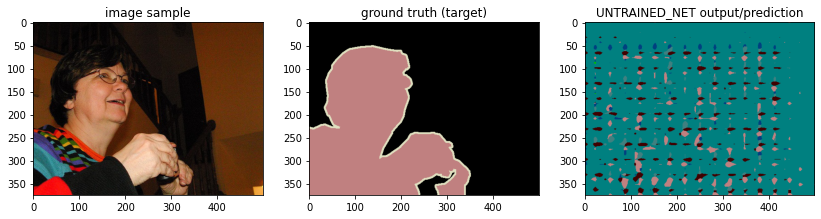

In [61]:
print(torch.cuda.get_device_name())

untrained_net = MyNet(21, (375,500)).eval()
sample_img, sample_target = sanity_joint_transform(*sample1)
# sample_img, sample_target = JointCenterCrop(256)(sample_img, sample_target)
# print(sample_img[None].size())
untrained_output = untrained_net.forward(sample_img[None])

# Convert to 375 x 500 image of int classes
sample_output = torch.argmax(untrained_output, dim=1).numpy()

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,3,1)
plt.title('image sample')
ax.imshow(sample1[0])
ax = fig.add_subplot(1,3,2)
plt.title('ground truth (target)')
ax.imshow(sample1[1])
ax = fig.add_subplot(1,3,3)
plt.title('UNTRAINED_NET output/prediction')
print(untrained_output.size())
ax.imshow(colorize_mask(sample_output[0]))
# ax.imshow(colorize_mask(untrained_output.numpy()[0]))


# Problem 3 

#### (a) Implement the loss function (Cross Entropy Loss). Do not use already implemented versions of this loss function.

Feel free to use functions like `F.log_softmax` and `F.nll_loss` (if you want to, or you can just implement the math).


In [62]:
# Student Answer:

# class MyCrossEntropyLoss(...):


#### (b) Compare against the existing CrossEntropyLoss function on your sample output from your neural network.

In [63]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
print(criterion)
print(sample_target[None].size())
print(untrained_output[0].size())
print(sample_target.size())
print(criterion(untrained_output, sample_target[None]))

# my_criterion = MyCrossEntropyLoss(ignore_index=255)

# print(my_criterion(untrained_output, sample_target[None]))
    

CrossEntropyLoss()
torch.Size([1, 375, 500])
torch.Size([21, 375, 500])
torch.Size([375, 500])
tensor(3.0413, grad_fn=<NllLoss2DBackward>)


# Problem 4

#### (a) Use standard function `eval_semantic_segmentation` (already imported from chainerCV) to compute "mean intersection over union" for the output of UNTRAINED_NET on sample1 (`untrained_output`) using the target for sample1. Read documentations for function  `eval_semantic_segmentation` to properly set its input parameters.

In [64]:
# Write code to propely compute 'pred' and 'gts' as arguments for function 'eval_semantic_segemntation'

np_target = sample_target.numpy().astype(np.int32)
np_target[np_target==255] = -1
initial_gts = np.array([np_target])

initial_pred = sample_output
print(initial_pred.shape)
initial_conf = eval_semantic_segmentation(initial_pred, initial_gts)

print("mIoU for the sample image / ground truth pair: {}".format(initial_conf['miou']))

(1, 375, 500)
mIoU for the sample image / ground truth pair: 0.008049473963645509


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


#### (b) Write the validation loop.

In [65]:
def validate(val_data_loader, net):
    iou_arr = []
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_data_loader):
            print("Tick: {}".format(i))
            inputs, masks = data

            print("shape: {}".format(masks.shape))

            if USE_GPU:
                net = net.cuda()
                masks = masks.cuda()
                inputs = inputs.cuda()

            outputs = net(inputs)

            np_target = masks[0].cpu().numpy().astype(np.int32)
            np_target[np_target == 255] = -1

            gts = np.array([np_target])
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            val_loss.append(criterion(outputs, masks))
            # Write menearest

            # Hint: make sure the range of values of the ground truth is what you expectg

            conf = eval_semantic_segmentation(preds, gts)

            iou_arr.append(conf['miou'])
    
    print(iou_arr)
    return val_loss, (sum(iou_arr) / len(iou_arr))

#### (c) Run the validation loop for UNTRAINED_NET against the sanity validation dataset.

In [66]:
%%time
print("mIoU over the sanity dataset:{}".format(validate(sanity_loader, untrained_net)[1]))

Tick: 0
shape: torch.Size([1, 375, 500])
max: 20
[0.008049473963645509]
mIoU over the sanity dataset:0.008049473963645509
CPU times: user 36.3 ms, sys: 193 ms, total: 229 ms
Wall time: 376 ms


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


# Problem 5

#### (a) Define an optimizer to train the given loss function.

Feel free to choose your optimizer of choice from https://pytorch.org/docs/stable/optim.html.


In [67]:
def get_optimizer(net):
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    return optimizer




#### (b) Write the training loop to train the network. 


In [68]:
import time

def train(train_data_loader, net, optimizer, loss_graph):
    for i, data in enumerate(train_data_loader):
        inputs, masks = data
    
        if USE_GPU:
            net = net.cuda()
            inputs = inputs.cuda()
            masks = masks.cuda()
        
        # Write me
        outputs = net(inputs)
        loss = net.criterion(outputs, masks)
        print("Training: On Tick: {} loss {}".format(i, loss))
        loss_graph.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # loss_graph.append() Populate this list to graph the loss
    
    return (sum(loss_graph) / len(loss_graph))

#### (c) Create OVERFIT_NET and train it on the single image dataset.
##### Single image training is helpful for debugging and hyper-parameter tuning (e.g. learning rate, etc.) as it is fast even on a single CPU. In particular, you can work with a single image until your loss function is consistently decreasing during training loop and the network starts producing a reasonable output for this training image. Training on a single image also teaches about overfitting, particualrly when comparing it with more thorough forms of network training. 

In [78]:
%%time
%matplotlib notebook
import time

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU). 
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets 
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training. 
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net. 
overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
overfit_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# You can change the number of EPOCHS
EPOCH = 100

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    new_loss_graph = []
    loss = train(sanity_loader, overfit_net, optimizer, new_loss_graph)
    loss_graph += new_loss_graph
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))
print("Final Loss: {}".format(loss))
%matplotlib inline
plt.show()

Starting Training...


<IPython.core.display.Javascript object>

max: 20
Training: On Tick: 0 loss 3.1255505084991455
Epoch: 0 Loss: 3.1255505084991455
max: 20
Training: On Tick: 0 loss 2.237344264984131
Epoch: 1 Loss: 2.237344264984131
max: 20
Training: On Tick: 0 loss 1.5843485593795776
Epoch: 2 Loss: 1.5843485593795776
max: 20
Training: On Tick: 0 loss 1.0719529390335083
Epoch: 3 Loss: 1.0719529390335083
max: 20
Training: On Tick: 0 loss 0.7100151181221008
Epoch: 4 Loss: 0.7100151181221008
max: 15
Training: On Tick: 0 loss 0.459166020154953
Epoch: 5 Loss: 0.459166020154953
max: 15
Training: On Tick: 0 loss 0.30693313479423523
Epoch: 6 Loss: 0.30693313479423523
max: 15
Training: On Tick: 0 loss 0.21972154080867767
Epoch: 7 Loss: 0.21972154080867767
max: 15
Training: On Tick: 0 loss 0.15131515264511108
Epoch: 8 Loss: 0.15131515264511108
max: 15
Training: On Tick: 0 loss 0.10976369678974152
Epoch: 9 Loss: 0.10976369678974152
max: 15
Training: On Tick: 0 loss 0.07942379266023636
Epoch: 10 Loss: 0.07942379266023636
max: 15
Training: On Tick: 0 loss 0.

#### Qualitative and quantitative evaluation of predictions (untrained vs overfit nets) - fully implemented.

max: 15
max: 20
(1, 375, 500)


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


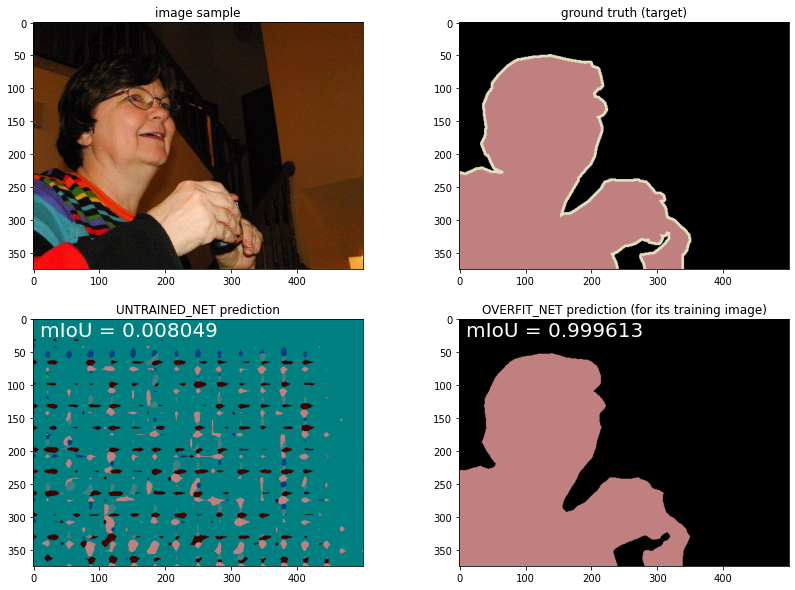

In [79]:
# switch back to evaluation mode
overfit_net.eval()

sample_img, sample_target = sanity_joint_transform(*sample1)
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

# gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts = sample_target.cpu().numpy()
gts[gts == 255] = -1
print(pred_O[None].shape)
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for its training image)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

max: 20
max: 20


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator


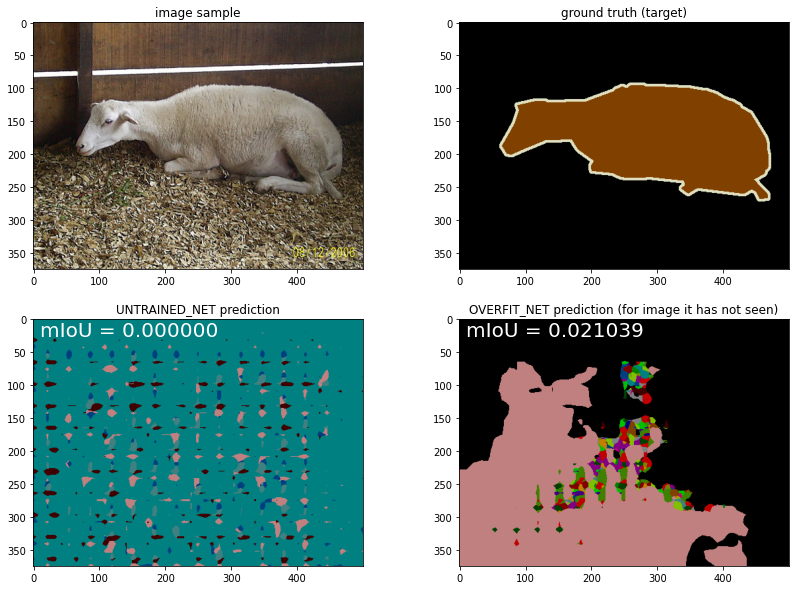

In [80]:
# img, target = JointResize((375,500))(*sample2)
sample_img, sample_target = sanity_joint_transform(*sample2)
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

# gts = target.numpy()#torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long().numpy()
gts = sample_target.cpu().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

#### Run the validation loop for OVERFIT_NET against the sanity dataset (an image it was trained on) - fully implemented

In [72]:
%%time
print("mIoU for OVERFIT_NET over its training image:{}".format(validate(sanity_loader, overfit_net)[1]))

Tick: 0
shape: torch.Size([1, 375, 500])
max: 15
[0.8920658430787738]
mIoU for OVERFIT_NET over its training image:0.8920658430787738
CPU times: user 27.4 ms, sys: 191 ms, total: 219 ms
Wall time: 368 ms


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


### WARNING: For the remaining part of the assignment (below) it is advisable to switch to GPU mode as running each validation and training loop on the whole training set takes over an hour on CPU (there are several such loops below). Note that GPU mode is helpful only if you have a sufficiently good NVIDIA gpu (not older than 2-3 years) and cuda installed on your computer. If you do not have a sufficiently good graphics card available, you can still finish the remaining part in CPU mode (takes a few hours), as the cells below are mostly implemented and test your code written and debugged in the earlier parts above. You can also switch to Google Colaboratory to run the remaining parts below.

### You can use validation-data experiments below to tune your hyper-parameters. Normally, validation data is used exactly for this purpose. For actual competitions, testing data is not public and you can not tune hyper-parameters on in. 

#### (d) Evaluate UNTRAINED_NET and OVERFIT_NET on validation dataset.
##### Run the validation loop for UNTRAINED_NET against the validation dataset:

In [73]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
# Takes 15min on Colab, 1500 images in validation set
# print("mIoU for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)[1]))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


##### Run the validation loop for OVERFIT_NET against the validation dataset (it has not seen): 

In [74]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
# print("mIoU for OVERFIT_NET over the validation dataset:{}".format(validate(val_loader, overfit_net)[1]))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


#### (e) Explain in a few sentences the quantitative results observed in (c) and (d):

Student answer:

#### (f) Create TRAINED_NET and train it on the full training dataset:

In [81]:
%%time
%matplotlib notebook

# torch.cuda.empty_cache()

# This training will be very slow on a CPU (>1hour per epoch). Ideally, this should be run in GPU mode (USE_GPU=True) 
# taking only a few minutes per epoch (depending on your GPU and batch size). Thus, before proceeding with this excercise,
# it is highly advisable that you first finish debugging your net code. In particular, make sure that OVERFIT_NET behaves 
# reasonably, e.g. its loss monotonically decreases during training and its output is OK (for the image it was trained on). 
# Below we create another (deep) copy of untrained_net. Unlike OVERFIT_NET it will be trained on a full training dataset.
trained_net = copy.deepcopy(untrained_net)
# overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# You can change the number of EPOCHS below. Since each epoch for TRAINED_NET iterates over all training dataset images,
# the number of required epochs could be smaller compared to OFERFIT_NET where each epoch iterates over one-image-dataset)
EPOCH = 30

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)
# optimizer = optim.SGD(trained_net.parameters(), lr=0.002, momentum=0.9)

print("Starting Training...")

loss_graph = []

# fig = plt.figure(figsize=(12,6))
# plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
# ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    print("Starting Epoch {}".format(e))
    new_loss_graph = []
    loss = train(train_loader, trained_net, optimizer, new_loss_graph)
    loss_graph += new_loss_graph
    # ax.clear()
    # ax.set_xlabel('iterations')
    # ax.set_ylabel('loss value')
    # ax.set_title('Training loss curve for TRAINED_NET')
    # ax.plot(loss_graph, label='training loss')
    # ax.legend(loc='upper right')
    # fig.canvas.draw()
    # plt.show()
    print("Epoch: {} Loss: {}".format(e, loss))
    
%matplotlib inline

Starting Training...
Starting Epoch 0
max: 20
Training: On Tick: 0 loss 3.1158158779144287
max: 20
Training: On Tick: 1 loss 2.785062551498413
max: 20
Training: On Tick: 2 loss 2.19210147857666
max: 20
Training: On Tick: 3 loss 2.0062015056610107
max: 18
Training: On Tick: 4 loss 1.5812275409698486
max: 18
Training: On Tick: 5 loss 1.6920326948165894
max: 19
Training: On Tick: 6 loss 1.6090527772903442
max: 15
Training: On Tick: 7 loss 1.4174072742462158
max: 15
Training: On Tick: 8 loss 1.4076223373413086
max: 19
Training: On Tick: 9 loss 1.3567227125167847
max: 15
Training: On Tick: 10 loss 1.4562236070632935
max: 0
Training: On Tick: 11 loss 1.1726374626159668
max: 15
Training: On Tick: 12 loss 1.3825024366378784
max: 0
Training: On Tick: 13 loss 1.314728856086731
max: 0
Training: On Tick: 14 loss 1.1762686967849731
max: 15
Training: On Tick: 15 loss 1.1434962749481201
max: 19
Training: On Tick: 16 loss 1.4560813903808594
max: 15
Training: On Tick: 17 loss 1.3561022281646729
max: 0


#### (g) Qualitative and quantitative evaluation of predictions (OVERFIT_NET vs TRAINED_NET):

max: 15
max: 15
torch.Size([1, 21, 375, 500])
15


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


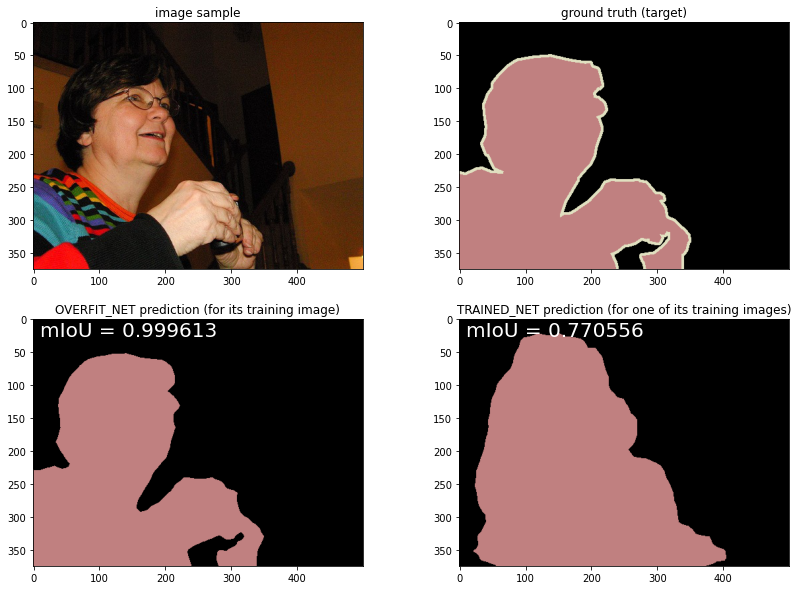

In [85]:
# switch back to evaluation mode
trained_net.eval()

sample_img, sample_target = sanity_joint_transform(*sample1)
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

print(sample_output_T.shape)

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
print(pred_T.max())
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for its training image)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for one of its training images)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

max: 20
max: 17


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator


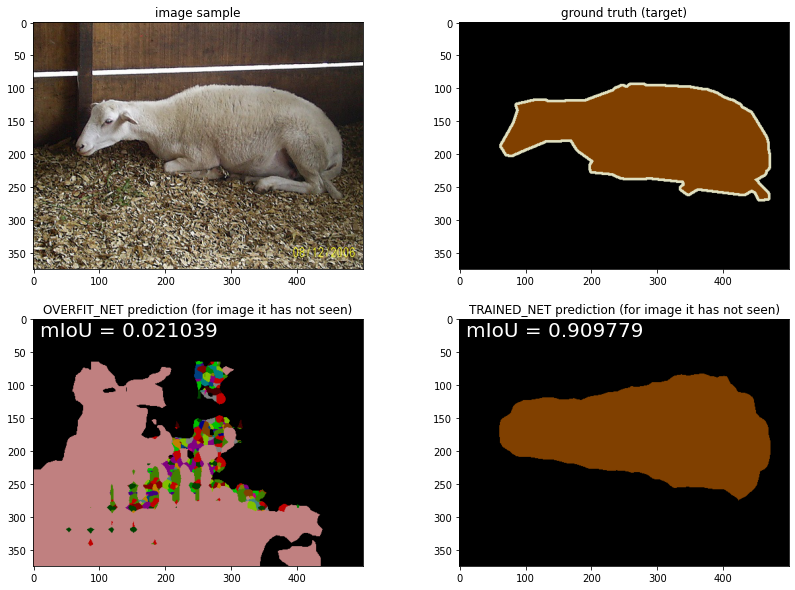

In [86]:
sample_img, sample_target = sanity_joint_transform(*sample2)
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

VOC Root: drive/My Drive/cs484/dataset
max: 20
max: 15


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


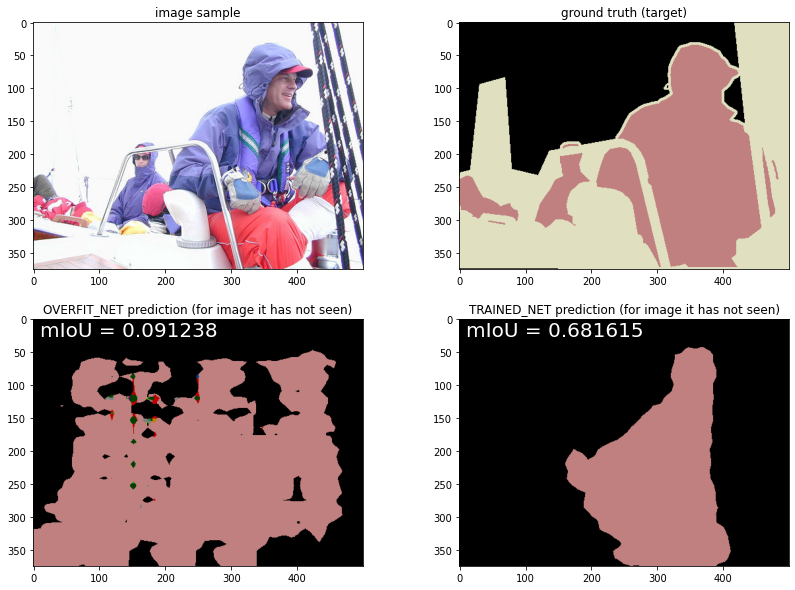

In [87]:
some_img = VOCSegmentation(DATASET_PATH, image_set='train', download = False)[500]

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*some_img))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(some_img[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(some_img[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(some_img[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

#### (h) Evaluate TRAINED_NET on validation dataset.
##### Run the validation loop for TRAINED_NET against the validation dataset (it has not seen): 

In [ ]:
%%time
# This will be slow on CPU (around 1 hour). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for TRAINED_NET over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

In [ ]:
# !pip install torchviz
# from torchviz import make_dot
# output = trained_net(JointToTensor()(*sample1)[0].unsqueeze(0))
# make_dot()

# Problem 6

#### For the network that you implemented, write a paragraph or two about limitations / bottlenecks about the work. What could be improved? What seems to be some obvious issues with the existing works?